# Catching close encounters and escaping planets using exceptions
Sometimes one is interested in catching a close encounter between two planets or planets escaping the planetary system. This can be easily done with REBOUND. What you do when a close encounter or an escape happens, is up to you.

Some integrators are better suited to simulate close encounters than other. For example, the non-symplectic integrator IAS15 has an adaptive timestep scheme that resolves close encounters very well. Integrators that use a fixed timestep WHFast are more likely to miss close encounters.

In this tutorial we'll start with a two-planet system that will go unstable on a short timescale:

In [1]:
import rebound
import numpy as np
def setupSimulation():
    rebound.reset()
    rebound.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1.)
    rebound.add(m=1e-3,a=1.)
    rebound.add(m=1e-3,a=1.25)
    rebound.move_to_com()

Let's integrate this system for 100 orbital periods.

In [2]:
setupSimulation()
rebound.integrate(100.*2.*np.pi)

Rebound exits the integration routine normally. We can now explore the final particle orbits:

In [3]:
for o in rebound.calculate_orbits():
    print(o)

<rebound.Orbit instance, a=1.3374239512456079 e=0.11214122057147514>
<rebound.Orbit instance, a=0.9435143095295784 e=0.07045492622646145>


We see that the orbits of both planets changed significantly and we can already speculate that there was a close encounter.

Let's redo the simulation, but this time set the `minD` flag in the integrate routine. If this flag is set, then REBOUND calculates the minimum distance between any two particle pairs. If the distance is less than `minD`, then the integration is stopped and an exception thrown. The [Hill radius](http://en.wikipedia.org/wiki/Hill_sphere) is given by $r_{\rm Hill} \approx a \sqrt{\frac{m}{3M}}$ which is approximately 0.06 in our case. Let's set the breakout flag `minD` to roughly three Hill radii and see what happens:

In [4]:
setupSimulation() # Resets everything
rebound.integrate(100.*2.*np.pi, minD=0.2)

CloseEncounter: A close encounter occured between particles 2 and 1.

As you see, we got an exception! Let's redo the simulation once again and store the particle distance while we're integrating. This time we'll also catch the exception with a try/except construct so that our script doesn't break.

In [6]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,100.*2.*np.pi,Noutputs)
distances = np.zeros(Noutputs)
ps = rebound.particles # ps is now an array of pointers. It will update as the simulation runs.
try:
    for i,time in enumerate(times):
        rebound.integrate(time,minD=0.2)
        dx = ps[1].x - ps[2].x
        dy = ps[1].y - ps[2].y
        dz = ps[1].z - ps[2].z
        distances[i] = np.sqrt(dx*dx+dy*dy+dz*dz)
except rebound.CloseEncounter as e:
    print("Close encounter detected at t=%f, between particles %d and %d." % (rebound.t, e.id1, e.id2))

Close encounter detected at t=67.549399, between particles 2 and 1.


Let plot the distance as a function of time.

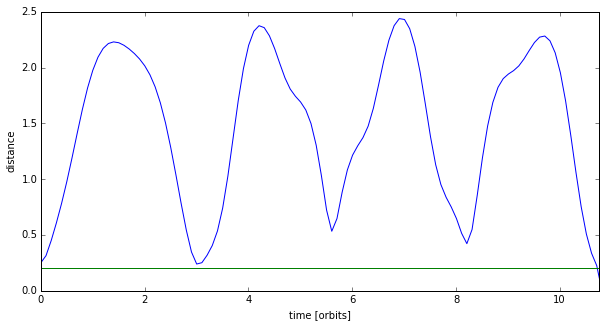

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlabel("time [orbits]")
ax.set_xlim([0,rebound.t/(2.*np.pi)])
ax.set_ylabel("distance")
plt.plot(times/(2.*np.pi), distances);
plt.plot([0.0,12],[0.2,0.2]) # Plot our close encounter criteria;

We did indeed find the close enounter correctly. We could now do something with the two particles that collided. 

Let's to the simplest thing, let's merge them. To do that we'll first calculate our new merged planet coordinates, then clear all particles from REBOUND and finally add the new particles.

In [9]:
import copy
def mergeParticles(id1,id2):
    old_ps = rebound.particles
    new_ps = []
    for i in range(rebound.N):
        if i!=id1 and i!=id2:
            new_ps.append(copy.deepcopy(old_ps[i]))        
    mergedPlanet = rebound.Particle()
    mergedPlanet.m  = old_ps[id1].m + old_ps[id2].m
    mergedPlanet.x  = (old_ps[id1].m*old_ps[id1].x  + old_ps[id2].m*old_ps[id2].x) /mergedPlanet.m
    mergedPlanet.y  = (old_ps[id1].m*old_ps[id1].y  + old_ps[id2].m*old_ps[id2].y) /mergedPlanet.m
    mergedPlanet.z  = (old_ps[id1].m*old_ps[id1].z  + old_ps[id2].m*old_ps[id2].z) /mergedPlanet.m
    mergedPlanet.vx = (old_ps[id1].m*old_ps[id1].vx + old_ps[id2].m*old_ps[id2].vx)/mergedPlanet.m
    mergedPlanet.vy = (old_ps[id1].m*old_ps[id1].vy + old_ps[id2].m*old_ps[id2].vy)/mergedPlanet.m
    mergedPlanet.vz = (old_ps[id1].m*old_ps[id1].vz + old_ps[id2].m*old_ps[id2].vz)/mergedPlanet.m
    new_ps.append(mergedPlanet)
    del(rebound.particles)
    rebound.add(new_ps)

setupSimulation() # Resets everything
print("Number of particles at the beginning of the simulation: %d."%rebound.N)
for i,time in enumerate(times):
    try:
        rebound.integrate(time,minD=0.2)
    except rebound.CloseEncounter as e:
        print("Close encounter detected at t=%f, between particles %d and %d. Merging." % (rebound.t, e.id1, e.id2))
        mergeParticles(e.id1,e.id2)
print("Number of particles at the end of the simulation: %d."%rebound.N)

Number of particles at the beginning of the simulation: 3.
Close encounter detected at t=67.549399, between particles 2 and 1. Merging.
Number of particles at the end of the simulation: 2.
